In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import matplotlib.pyplot as plt
import yaml


from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms

In [57]:
np.random.seed(1000)
class Param_Inferencer:
    def __init__(self) -> None:
        # List of parameters to infer
        self.list_of_param = ['T_peak', 'T_slope']
        # Number of paramters to infer
        self.param_to_infer = len(self.list_of_param)
        self.variances_to_infer = len(self.list_of_param)
        # Sample vector
        #self.thetas = np.random.rand(self.param_to_infer + 1).reshape(1,-1) # First one is random + likelihood
        self.thetas = np.random.rand(self.param_to_infer + self.variances_to_infer).reshape(1,-1) # First one is random + likelihood
        # Burnin
        self.burnin = None

        # Current model and model parameters
        self.model = None
        self.dt = 0.025
        self.commands = get_folder_path()+'/open_loop_inputs/open_loop_commands.csv'
        self.N = get_csv_row_count(self.commands)
        self.open_loop_tf = self.N*self.dt
        # T_peak and T_slope is not specified since we infer those
        self.x_vect_ref = self.get_x_vect_ref()
        self.y_likelihood = 0


    def get_x_vect_ref(self):
        T_peak_ref = 0.37
        T_slope_ref = 0.4
        self.model = FourWheelModel(self.dt,self.open_loop_tf, T_peak_ref, T_slope_ref)
        t,x = self.get_open_loop_data()
        return x
    
    # Example usage
    def get_kpi(self, tetha):
        self.generate_new_model(tetha[:self.param_to_infer])
        t,x_vect = self.get_open_loop_data()
        
        l2_norm_position = np.linalg.norm(self.x_vect_ref[:,:2] - x_vect[:,:2], axis=1).sum()
        l2_norm_velocity = np.linalg.norm(self.x_vect_ref[:,2:] - x_vect[:,2:], axis=1).sum()

        w1 = 0.5
        w2 = 0.5
        kpi = w1*l2_norm_position+w2*l2_norm_velocity
        return kpi


    def get_open_loop_data(self):
        
        t,x_vect = self.model.do_open_loop_sim_from_csv(self.commands)
        
        x = x_vect[:,0]
        y = x_vect[:,1]

        
        return t,x_vect



    def do_open_loop_sim_and_compare(self, thetas):
        kpis = []
        self.generate_new_model(thetas[:self.param_to_infer])
        t,x_vect = self.get_open_loop_data()
        for i in range(0,int(self.x_vect_ref.shape[1]),6):
            x_ref = self.x_vect_ref[:,i:i+6]
            #print('x_ref:')
            #print(x_ref)
            kpi = self.get_kpi(x_ref, x_vect)
            kpis.append(kpi)
        kpis = np.array(kpis).reshape(-1,1)
        #print(kpis.shape)
        
        #print(kpis)
        return kpis

    def get_kpi(self, x_ref, x_vect):
        
        
        l2_norm_position = np.linalg.norm(x_ref[:,:2] - x_vect[:,:2], axis=1).sum()
        l2_norm_velocity = np.linalg.norm(x_ref[:,2:] - x_vect[:,2:], axis=1).sum()

        w1 = 0.5
        w2 = 0.5
        kpi = w1*l2_norm_position+w2*l2_norm_velocity
        return kpi



    
    def generate_new_model(self, Tetha):
        T_peak = Tetha[0]
        T_slope = Tetha[1]
        self.model = FourWheelModel( self.dt, self.open_loop_tf,float(T_peak), float(T_slope))

    #----------------- Functions from here take care of the inference -----------------#

    def proposal(self, prec_theta, search_width = 0.5):
        # this function generates the proposal for the new theta
        # we assume that the distribution of the random variables 
        # is normal for the first two and gamma for the third.
        # conditional on the previous value of the accepted parameters (prec_theta)

        unkown_param = 500 #default = 500
        out_theta = np.zeros(self.param_to_infer+self.variances_to_infer)
        out_theta[:self.param_to_infer] = sc.multivariate_normal(mean=prec_theta[:self.param_to_infer],cov=np.eye(self.param_to_infer)*search_width**2).rvs(1)
        #the last component is the noise
        out_theta[self.param_to_infer] = sc.gamma(a=prec_theta[self.param_to_infer]*search_width*unkown_param, scale=1/(unkown_param*search_width)).rvs()
        
        #two different variances
        if self.variances_to_infer > 1:
            out_theta[self.param_to_infer+1] = sc.gamma(a=prec_theta[self.param_to_infer+1]*search_width*unkown_param, scale=1/(unkown_param*search_width)).rvs()
        
        return out_theta
    
    '''def log_likelihood(self, tetha):
        proposed_kpi = self.get_kpi(tetha)
        #proposed_radius = self.get_circle_radius(tetha)
        #mean = np.full(self.y_likelihood.shape[0], proposed_radius).reshape(-1,1)
        log_likelihood_vect = sc.norm.logpdf(self.y_likelihood, loc= proposed_kpi, scale=tetha[self.param_to_infer]) # Loc will be simulation(theta(:param_to_infer), scale = theta[param_to_infer])
        log_likelihood_out = np.sum(log_likelihood_vect)
        return log_likelihood_out'''
    
    def log_likelihood(self, theta):
            mean = self.do_open_loop_sim_and_compare(theta)
            log_likelihood_vect = sc.norm.logpdf(self.y_likelihood, loc= mean, scale=theta[self.param_to_infer]) # Loc will be simulation(theta(:param_to_infer), scale = theta[param_to_infer])
            log_likelihood_out = np.sum(log_likelihood_vect)
            return log_likelihood_out

    def log_prior(self, theta):

        unknown_param = 100 # default = 100
        # evaluate the prior for the parameters on a multivariate gaussian. 
        prior_out = sc.multivariate_normal.logpdf(theta[:self.param_to_infer],mean=np.zeros(self.param_to_infer), cov=np.eye(self.param_to_infer)*unknown_param)
        # this needs to be summed to the prior for the sigma, since I assumed independence.
        prior_out += sc.gamma.logpdf(theta[self.param_to_infer], a=1, scale=1)
        return prior_out


    def log_proposal_x_given_y(self, x,y, search_width = 10):
        walk = 1
        # Parameters
        log_proposal_param = sc.multivariate_normal.logpdf(x[:self.param_to_infer],mean=y[:self.param_to_infer], cov=np.eye(self.param_to_infer)*search_width**2)
        # Standard deviation
        log_proposal_std_dev = sc.gamma.logpdf(x[self.param_to_infer], a=y[self.param_to_infer]*walk*500, scale=1/(500*walk))
        
        log_proposal_x_given_y = log_proposal_param+log_proposal_std_dev
        return log_proposal_x_given_y

    def acceptance_prob(self, log_likelihood_theta, log_likelihood_theta_new, log_prior_theta, log_prior_theta_new, log_proposal_theta_given_theta_new, log_proposal_theta__new_given_theta):
        prop_ratio = log_proposal_theta_given_theta_new-log_proposal_theta__new_given_theta
        likelihood_prior_proposal_ratio = -log_likelihood_theta_new + log_likelihood_theta - \
                                log_prior_theta_new + log_prior_theta - prop_ratio
        return np.exp(likelihood_prior_proposal_ratio)

    def inference(self):
        # Number of samples accepted/rejected
        accepted = 0
        rejected = 0
        # Number of iterations
        iter = 700
        # Scale facter of the covariance matrix
        width = 0.1
        
        accepted_thetas = np.full(self.param_to_infer + self.variances_to_infer, 0.5).reshape(1,-1) #np.random.rand(self.param_to_infer + 1).reshape(1,-1)
        rejected_thetas = np.empty(self.param_to_infer + self.variances_to_infer).reshape(1,-1)
        all_thetas = np.concatenate((accepted_thetas, np.zeros((accepted_thetas.shape[0], 1))), axis=1)
        # Loop for the inference
        for i in range(iter):
            # 1) Provide a proposal for theta
            theta_new = self.proposal(accepted_thetas[-1,:], search_width=width)

            # 2) Compute log-likelihood of the new theta and the old one
            log_likelihood_theta = self.log_likelihood(accepted_thetas[-1,:])
            log_likelihood_theta_new = self.log_likelihood(theta_new)

            # 3) Compute log-prior of the new theta and the old one
            log_prior_theta = self.log_prior(accepted_thetas[-1,:])
            log_prior_theta_new = self.log_prior(theta_new)

            # 4) Compute log-proposal of the new theta and the old one
            log_proposal_theta_given_theta_new = self.log_proposal_x_given_y(accepted_thetas[-1,:], theta_new, search_width =width)
            log_proposal_theta__new_given_theta = self.log_proposal_x_given_y(theta_new, accepted_thetas[-1,:], search_width =width)

            # 5) Compute the acceptance probability
            alpha = self.acceptance_prob(log_likelihood_theta, log_likelihood_theta_new, log_prior_theta, log_prior_theta_new, log_proposal_theta_given_theta_new, log_proposal_theta__new_given_theta)

            #6) Generate a uniform number u from [0,1]
            '''u = sc.uniform().rvs()
            # if u <= alpha, accept the new sample
            if u <= alpha:
                thetas = np.vstack((thetas,theta_new))
                accepted += 1
            else:
                rejected += 1''' 
            u = sc.uniform().rvs()
            if alpha <= u:
                accepted_thetas = np.vstack((accepted_thetas,theta_new))
                accepted += 1
                theta_new_all_thetas = np.hstack((theta_new, np.array([1]).reshape(-1,)))
            else:
                rejected_thetas = np.vstack((rejected_thetas,theta_new))
                rejected += 1
                theta_new_all_thetas = np.hstack((theta_new, np.array([0]).reshape(-1,)))
            
            all_thetas = np.vstack((all_thetas,theta_new_all_thetas))

            if i%50 == 0:
                print(f"Iteration {i}: {accepted} accepted, {rejected} rejected")
        
        return accepted_thetas, rejected_thetas, all_thetas

In [58]:
PI = Param_Inferencer()

accepted_thetas, rejected_thetas, all_thetas = PI.inference()

Iteration 0: 1 accepted, 0 rejected


/var/folders/mw/9cttllqs2yv0dqrlc62m0l8h0000gn/T/ipykernel_7630/1770115001.py:152: RuntimeWarning: overflow encountered in exp
  return np.exp(likelihood_prior_proposal_ratio)


In [ ]:
all_thetas.shape

(301, 5)

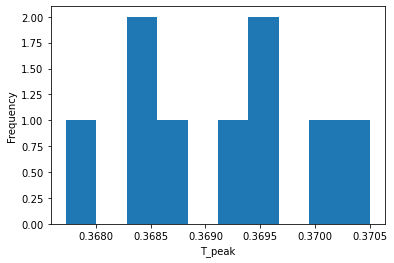

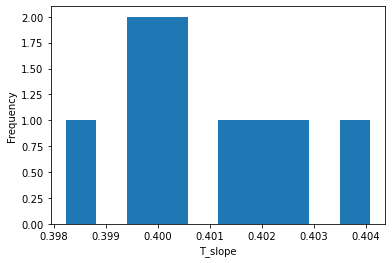

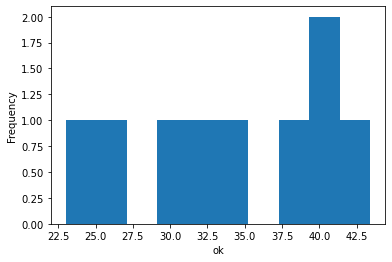

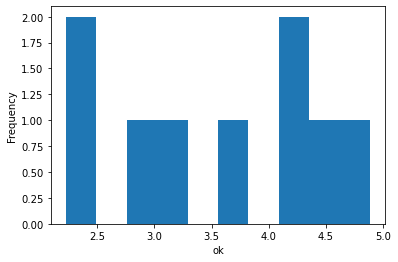

In [ ]:
plot_column_histograms(accepted_thetas[32:], ['T_peak', 'T_slope', 'ok', 'ok'])

(0.40098156182081207, 0.010161274217271267)


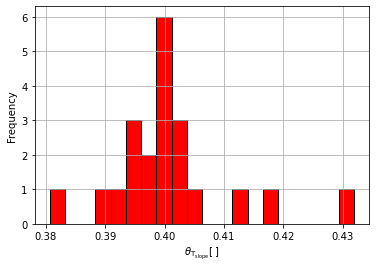

In [ ]:
burn_in = int(accepted_thetas.shape[0]*0.5)
thetas_burned = accepted_thetas[burn_in:, :]
thetas_burned.shape
res = sc.norm.fit(thetas_burned[:,1])
print(res)
plt.hist(thetas_burned[:,1], bins=20, edgecolor='black', color = 'red')
plt.xlabel(r'$\theta_{\rm T_{slope}}  [\;]$')
plt.ylabel(r'Frequency')
plt.grid(True)

# Show the plot
plt.show()